# XGBoost Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)
This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

## Why We Chose XGBoost for Bitcoin Fee Forecasting?

XGBoost is a gradient-boosted tree model that performs exceptionally well on structured tabular data. It can capture complex nonlinear relationships, handle missing values, and provide clear feature importance — all with minimal preprocessing effort.

- **Nonlinear pattern modeling:** Effectively captures temporal trends and interactions between mempool and market signals.

- **Robust to multicollinearity:** Handles correlated fee features (e.g., hourFee, halfHourFee) without degradation in performance.

- **Interpretability:** Outputs feature importance, helping us understand which signals drive predictions.

- **Practical baseline:** Provides strong performance with fast training and low overhead.

This notebook demonstrates the full training and evaluation pipeline of XGBoost.
> **Code Location**: See `scripts/baseline_xgboost.py` for the main model implementation and training pipeline.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../scripts/xgboost")
from xgboost_utils import create_lag_features_fast
from xgboost_predict import predict_xgboost
sys.path.append("../src")
from plot_series import plot_series
from preprocess_raw_parquet import preprocess_raw_parquet

In [26]:
# Define key modeling parameters
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min

## 1. Data Loading
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [13]:
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Create lag features

We construct lag features for the target variable `recommended_fee_fastestFee` to help the XGBoost model learn from recent history.
Since our data is sampled every 15 minutes, we create 192 lag features to cover the past 48 hours.

In [14]:
lags = range(1, 193)  # 48 hours of 15-minute intervals
df_lag = create_lag_features_fast(df, 'recommended_fee_fastestFee', lags)
df_lag.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_183,recommended_fee_fastestFee_lag_184,recommended_fee_fastestFee_lag_185,recommended_fee_fastestFee_lag_186,recommended_fee_fastestFee_lag_187,recommended_fee_fastestFee_lag_188,recommended_fee_fastestFee_lag_189,recommended_fee_fastestFee_lag_190,recommended_fee_fastestFee_lag_191,recommended_fee_fastestFee_lag_192
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Why This Step Is Crucial
- **Encodes temporal dependencies** such as recent trends, reversals, and momentum in fee rate behavior.

- **Avoids data leakage** by only using past information to predict future values.

- **Supports tabular modeling** by converting time series into a flat structure usable by tree-based models like XGBoost.

## 3. Hyperparameter Optimization

In this step, we define and search for the best hyperparameter configuration to optimize XGBoost for forecasting Bitcoin transaction fees. The tuning process uses a randomized search approach, which balances efficiency and model robustness when exploring a large parameter space.

The following hyperparameters were tuned:

- Number of estimators, tree depth, and learning rate to control model complexity and convergence

- Row and column subsampling ratios to improve generalization

- Regularization terms (`reg_alpha`, `reg_lambda`, `gamma`) to prevent overfitting

- Constraints like `min_child_weight` and `max_delta_step` to stabilize splits and reduce sensitivity to noise

All tuning logic is implemented in the script:`scripts/xgboost/xgboost_model_optimization.py`

In [24]:
param_dist = {
        'estimator__n_estimators': [50, 100, 150, 200],              # Number of boosting rounds
        'estimator__max_depth': [2, 3, 4, 5, 6],                     # Tree depth
        'estimator__learning_rate': [0.005, 0.01, 0.05, 0.1],        # Step size shrinkage
        'estimator__subsample': [0.6, 0.8, 1.0],                     # Row sampling
        'estimator__colsample_bytree': [0.6, 0.8, 1.0],              # Feature sampling
        'estimator__gamma': [0, 1, 3, 5],                            # Min loss reduction to split
        'estimator__reg_lambda': [1, 5, 10, 20],                     # L2 regularization
        'estimator__reg_alpha': [0, 1, 5, 10],                       # L1 regularization
        'estimator__min_child_weight': [1, 3, 5],                    # Min sum hessian in leaf
        'estimator__max_delta_step': [0, 1, 3],                      # Step constraint (often 0)
    }


### Why This Step Is Crucial for XGBoost

- Ensures the model can learn complex fee dynamics without overfitting

- Stabilizes tree-based learning with structured regularization

- Aligns training with lag-based feature engineering

- Supports modular integration with cross-validation pipelines

#### Insights from Hyperparameter Tuning
The selected hyperparameters reflect a trade-off between flexibility and generalization. Moderate tree depths and learning rates prevent overfitting on noisy fee spikes, while regularization parameters control unnecessary splits. Subsampling further enhances robustness in a high-dimensional feature space.

These choices confirm our initial expectation that Bitcoin fee series exhibit both nonlinearity and temporal bursts. The tuned XGBoost model leverages these properties to deliver responsive and stable forecasts.

## 4. (OPTIONAL) Model Generalization Experimentation

To assess how well XGBoost generalizes over time, we implement three weekly cross-validation strategies:

- **Expanding Window**: Trains from week 1 and expands one week at a time. 

- **Sliding Window**: Uses a fixed 1-week window that shifts forward.  

- **Reverse Expanding Window**: Starts from the second-to-last week and expands backward.  

All windowing logic is implemented in:  `scripts/experimentation/xgboost_window.py`
> **Note:** This script also includes instructions on how to run the experiments and generate results.

### 4.1 Expanding Window Forecasting - Weekly

We use expanding window cross-validation to evaluate XGBoost’s performance by adding the most recent weekly data (+7-day training, 1-day testing). This simulates a real-world setup where the model is retrained weekly using all past data and evaluated on the upcoming week.

**Key motivations:**

- Test HWES’s stability over longer time horizons  

- Identify periods of high error (e.g., spikes, market shifts)  

- Improve model readiness for production retraining  

Saved output: `results/tables/xgboost/expanding_window_weekly_predictions.csv`

In [16]:
expanding_metrics = pd.read_csv("../results/tables/xgboost/expanding_window_weekly_predictions.csv")
expanding_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,1.6519,0.4355,0.5951,0.6213,0.2249,0.7243
1,2,2.1419,0.6634,0.7415,0.7370,0.2184,0.9719
2,3,3.9335,1.4710,1.2649,1.1977,0.3131,1.7996
3,4,2.7143,0.8505,0.8526,1.0112,0.6669,1.2055
4,5,2.5934,0.8381,0.8509,0.9043,0.4961,1.0631
5,6,2.6061,0.8859,0.8657,0.8544,0.2662,1.1205
6,7,7.8362,2.6992,2.4026,2.7345,0.2833,4.1982
7,8,2.4857,0.8119,0.8124,0.8614,0.1987,1.1125
8,9,2.0167,0.6648,0.6780,0.6738,0.2068,0.8843


#### Insights from Weekly Expanding Window Results

- **Strong performance in stable periods (Weeks 1–2, 8–9)**: XGBoost achieves low error metrics (e.g., MAE ≈ 0.62–0.67) and relatively low custom loss, indicating effective learning of regular weekly patterns.

- **Performance drop under volatility (Week 3 and 7)**: Error metrics spike in Week 3 (MAE = 1.20) and especially Week 7 (MAE = 2.73, custom loss = 7.83), reflecting the model’s sensitivity to sudden fee surges and increased variance.

- **Recovery trend (Weeks 8–9)**: After the volatility period, error metrics return to lower levels, showing the model’s ability to re-stabilize with more consistent input conditions.

These results suggest that XGBoost can effectively capture short-term dynamics in stable periods, while performance may temporarily degrade under abnormal volatility before recovering.

### 4.2 Expanding Window Forecasting – Weekly – Reverse

We use reverse expanding window cross-validation to examine how the inclusion of different historical periods affects XGBoost’s ability to forecast the same target period.  
The model always predicts the **last 24 hours**, while the training window grows **backward** step by step in weekly increments. This setup simulates situations where older and older historical data is gradually added to training.

**Key motivations:**

- Evaluate XGBoost’s temporal sensitivity to historical context  

- Assess robustness to structural changes in past data  

- Understand how training on different time ranges impacts forecast stability  

Saved output: `results/tables/xgboost/expanding_window_reverse_weekly_predictions.csv`

In [17]:
expanding_reverse_metrics = pd.read_csv("../results/tables/xgboost/expanding_window_reverse_weekly_predictions.csv")
expanding_reverse_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,2.1775,0.6873,0.7138,0.7765,0.2933,0.9679
1,2,2.1309,0.6539,0.7199,0.7571,0.2752,0.9764
2,3,2.3360,0.7646,0.7272,0.8443,0.3310,1.0306
3,4,2.3339,0.7850,0.7399,0.8090,0.3058,1.0178
4,5,2.2820,0.7542,0.7467,0.7810,0.2808,1.0289
5,6,2.2316,0.7463,0.7427,0.7425,0.2601,1.0190
6,7,2.2989,0.7819,0.7489,0.7681,0.2756,1.0290
7,8,2.3132,0.7921,0.7474,0.7738,0.2802,1.0300
8,9,2.3202,0.8011,0.7462,0.7729,0.2802,1.0325


#### Insights from Reverse Expanding Window Results

- **Stable performance across historical windows (Weeks 1–9)**: Metrics remain consistent across all folds (MAE ≈ 0.74–0.84, custom loss ≈ 2.13–2.34), indicating the model’s robustness to varying historical data lengths and low sensitivity to structural drift.

- **Minor fluctuations with longer lookback**: Slight increases in error metrics (e.g., Week 3 MAE = 0.8443) suggest some diminishing returns as older data becomes less informative for future predictions.

- **No volatility shocks observed**: Unlike forward tests, reverse expanding windows show no abrupt performance degradation, reflecting the smoother historical training segments.

These results confirm that XGBoost handles extended historical context well and maintains stable accuracy when trained on earlier data segments.

### 4.3 Sliding Window Forecasting – Weekly

We apply a **sliding window** strategy using a fixed 7-day training window and a 1-day test window (96 × 15-minute intervals).  
This setup simulates a realistic retraining schedule where the model is updated regularly using only the most recent week of data.

**Key motivations:**

- Evaluate XGBoost’s short-term adaptability across time  

- Examine model behavior under a fixed training history  

- Identify periods of degraded performance (e.g., sudden fee spikes)  

Saved output:  
`results/tables/xgboost/sliding_window_weekly_predictions.csv`

In [18]:
sliding_metrics = pd.read_csv("../results/tables/xgboost/sliding_window_weekly_predictions.csv")
sliding_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,1.6519,0.4355,0.5951,0.6213,0.2249,0.7243
1,2,2.4831,0.8555,0.8171,0.8105,0.2436,1.0645
2,3,4.0781,1.5077,1.2868,1.2836,0.3644,1.8098
3,4,2.4256,0.8259,0.7932,0.8065,0.4621,0.9949
4,5,2.1736,0.6161,0.7818,0.7757,0.3633,0.9449
5,6,2.8682,1.0128,0.9243,0.9311,0.2584,1.2907
6,7,13.5704,5.4081,4.2147,3.9476,0.3553,6.6432
7,8,2.3203,0.7190,0.7919,0.8094,0.1979,1.0002
8,9,1.9500,0.5845,0.6707,0.6948,0.2019,0.9105


#### Insights from Sliding Window Results

- **Stable performance during normal weeks (Weeks 1–2, 4–6, 8–9)**: Most weeks show consistent error levels (e.g., MAE ≈ 0.75–0.93), suggesting the model performs well under stable fee patterns using a fixed training window.

- **Severe performance drop during volatility (Week 7)**: All metrics spike sharply (MAE = 3.95, RMSE = 6.64), reflecting XGBoost's high sensitivity to distribution shifts when training history lacks recent data.

- **Quick rebound after disruption**: Performance quickly stabilizes by Week 8, showing that the model can recover when the test data returns to normal patterns.

These findings illustrate the trade-off in fixed-window training: strong local performance, but vulnerability to sudden outliers if past data is unrepresentative.


### Why This Step Is Crucial

Cross-validation using weekly windowing strategies is essential to assess model reliability across realistic, time-evolving scenarios.

- **Expanding window** evaluates how well the model learns from accumulating historical data.

- **Sliding window** focuses on short-term adaptability when retraining is done on a fixed-length recent history.

- **Reverse expanding window** examines how training history from the future impacts performance on earlier periods.

Together, these strategies:

- Uncover time periods where model performance becomes unstable (e.g., spikes, structural changes)

- Reveal how training scope and recency influence generalization and adaptability

- Provide insight into the temporal robustness of XGBoost across evolving market dynamics

This layered validation builds confidence in model behavior under both static and volatile fee conditions, supporting practical deployment with periodic retraining.

## 5. Forecasting and Evaluation

We train the final XGBoost model on the full dataset, excluding the most recent 24 hours to match our evaluation strategy. This approach ensures that the model does not overfit to the latest data, especially when recent spikes might distort performance.

We load the optimized model from `results/models/xgboost.pkl` and apply it to the most recent 1-day holdout window (2025-05-10 to 2025-05-11). The final forecast is evaluated using previously defined metrics such as MAE, RMSE, and our custom composite loss.

In [27]:
df_new = df.iloc[:-PRED_STEPS]
df_new_test = df_new.iloc[-PRED_STEPS:]
df_new_test = df_new_test.reset_index()
model_path = "../results/models/xgboost.pkl"
df_forecast, metrics = predict_xgboost(df,df_new_test,model_path)

In [28]:
metrics

,value
custom_loss,2.5817
std_diff,0.7081
dev_error,0.8803
mae,0.9933
mape,0.5397
rmse,1.2303


#### Insights from Final XGBOOST Model Results:
The final XGBoost model was evaluated on the most recent 1-day holdout window. It produced stable performance across all metrics, showing that the model generalized reasonably well to new data. However, some signs of degradation were observed, likely caused by sudden fee spikes near the forecast horizon.

This result aligns with patterns seen in the sliding window evaluation, reinforcing the importance of continuous monitoring and retraining to adapt to abrupt structural changes in transaction fees.

### Why This Step Is Crucial
- This represents the finalized XGBoost model, trained with all historical data except the holdout period, mirroring a real-world deployment scenario.

- Excluding the last 24 hours prevents leakage and allows evaluation on unseen data.

- Ensures consistent comparison across all baseline models using the same holdout period.

- Loading the saved model enables reproducible inference and supports integration with other downstream components (e.g., dashboards or APIs).

## 6. Forcast Visualization

We plot the XGBoost model’s **1-day forecast** against actual observations over the final 24 hours.  
This provides a final visual check on how well the model tracks short-term fee dynamics.

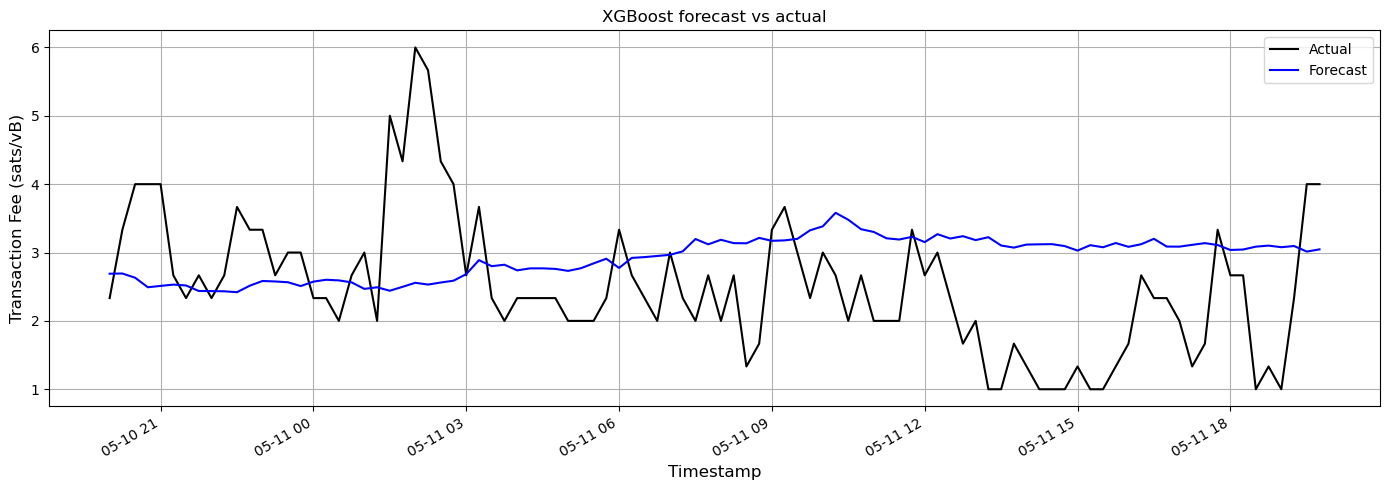

In [22]:
plot_series(df_forecast, sid = "recommended_fee_fastestFee")
plt.title("XGBoost forecast vs actual")
plt.tight_layout()
plt.show()

The forecast plot confirms:

- XGBoost captures general trend levels, especially during calm periods

- Forecasted values are smoother than observed fees, missing sharp surges

- Reinforces the importance of volatility-aware features for spiky regions

## 7. Conclusion: XGBoost for Bitcoin Fee Forecasting
In this notebook, we trained and evaluated an XGBoost model for short-term Bitcoin transaction fee prediction. The model was trained on 15-minute interval data and tested on a 1-day holdout window using a consistent evaluation pipeline.

**Key Takeaways:**

- XGBoost performs well in stable periods, capturing general patterns and yielding reasonable MAE and RMSE scores.

- The model is fast to train and supports scalable inference, making it practical for deployment.

- However, XGBoost tends to smooth over local volatility and underestimates sudden fee spikes.

- Visual and metric-based evaluation suggest that while XGBoost is competitive, additional spike-aware features could enhance responsiveness.

This XGBoost pipeline supports:

- Integration into hybrid or ensemble forecasting systems

- Benchmarking against time series and deep learning models like SARIMA or TFT

- Fast retraining for responsive deployment in dynamic network conditions

- By incorporating XGBoost into our evaluation framework, we establish a robust and scalable baseline for exploring gradient-boosted models and their extensions in future development.